In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from scimba_jax.linear_approximation.meshes.meshes1d import Mesh1D
from scimba_jax.linear_approximation.quad.gauss_quad import UnitSquareTensorized
from scimba_jax.mapping.mapping import Mapping, InvertibleFunction

Scimba_jax uses device: [CudaDevice(id=0)]
Scimba_jax uses dtype: <class 'jax.numpy.float64'>


## Maillage 1D

In [2]:
# Créer une quadrature 1D avec ordre 2
quad_1d = UnitSquareTensorized(dim=1, order=2)

# Créer un mapping trivial (identité sur [0,1])
identity = InvertibleFunction(
    f=lambda x: x,      # f(x) = x
    f_inv=lambda y: y   # f^-1(y) = y
)
mapping = Mapping([identity])

# Créer le maillage 1D avec 10 cellules
mesh_1d = Mesh1D(
    dim=1,
    n_cells=400,
    ref_quad=quad_1d,
    mapping=mapping
)

print("✓ Maillage 1D créé !")
print(f"  - Dimension: {mesh_1d.dim}")
print(f"  - Nombre de cellules: {mesh_1d.n_cells}")
print(f"  - Nombre total de cellules: {mesh_1d.n_cells_total}")
print(f"  - Points de quadrature par cellule: {mesh_1d.n_gauss}")
print(f"  - Nombre de faces: {mesh_1d.n_faces}")

✓ Maillage 1D créé !
  - Dimension: 1
  - Nombre de cellules: 400
  - Nombre total de cellules: 400
  - Points de quadrature par cellule: 2
  - Nombre de faces: 401


In [3]:
# Récupérer les nœuds du maillage
mesh_nodes_logical = mesh_1d.n_i_faces / mesh_1d.n_cells  # [0, 1/10, 2/10, ..., 1]
x_complete = np.asarray(mesh_1d.mapping.local_mapping(mesh_nodes_logical))
N = len(x_complete) # Nombre total de nœuds

# Récupérer les points intérieurs (excluant les bords)
x_int = x_complete[1:-1]
N_int = len(x_int) # Nombre de nœuds intérieurs
h = x_complete[1] - x_complete[0]  # Pas d'espace (obtenu du maillage)

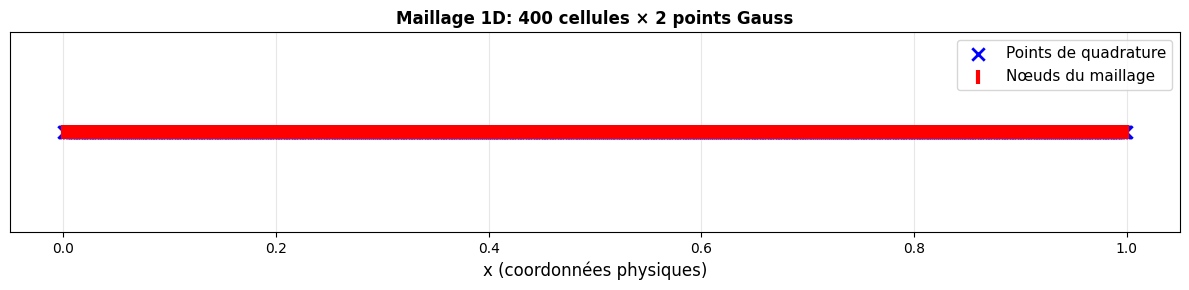

✓ Maillage 1D visualisé:
  • Nœuds: 401
  • Cellules: 400
  • Points Gauss/cellule: 2
  • Total points quadrature: 800


In [4]:
# Plot simplifié du mesh_1d
plt.close('all')  # Fermer toutes les figures précédentes
fig, ax = plt.subplots(figsize=(12, 3))

# Récupérer tous les points de quadrature via la classe
quad_points = mesh_1d.evaluate_mesh_points()  # shape: (n_cells, n_gauss, 1)
quad_points_flat = np.asarray(quad_points).flatten()

# Nœuds du maillage
mesh_nodes_logical = mesh_1d.n_i_faces / mesh_1d.n_cells
mesh_nodes_phys = np.asarray(mesh_1d.mapping.local_mapping(mesh_nodes_logical))

# Affichage
ax.scatter(quad_points_flat, np.zeros_like(quad_points_flat), s=80, c='blue', marker='x', linewidths=2, label='Points de quadrature', zorder=4)
ax.scatter(mesh_nodes_phys, np.zeros_like(mesh_nodes_phys), s=100, c='red', marker='|', linewidths=3, label='Nœuds du maillage', zorder=5)

ax.set_xlabel('x (coordonnées physiques)', fontsize=12)
ax.set_ylabel('')
ax.set_title(f'Maillage 1D: {mesh_1d.n_cells} cellules × {mesh_1d.n_gauss} points Gauss', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([-0.1, 0.1])
ax.set_yticks([])

plt.tight_layout()
plt.show()

print(f"✓ Maillage 1D visualisé:")
print(f"  • Nœuds: {mesh_1d.n_faces}")
print(f"  • Cellules: {mesh_1d.n_cells}")
print(f"  • Points Gauss/cellule: {mesh_1d.n_gauss}")
print(f"  • Total points quadrature: {mesh_1d.n_cells * mesh_1d.n_gauss}")

## Problème linéaire 1D

**Problème :** Considérons le problème de Poisson 1D avec terme de masse paramétré par $\alpha > 0$ :

$$\left\{\begin{align*}
-u''(x)+\alpha u(x) &= f(x),\quad x\in(0,1) \\
u(0) = u(1) &= 0\end{align*}\right.$$

Pour la résolution numérique, on fixe **$\alpha = 5$**, puis on étudiera la sensibilité de la solution à ce paramètre.

On considère la solution analytique $$u(x,\alpha) = \alpha\sin(2 \pi x).$$

**Schéma DF :** On considère un schéma différences finies (centré d'ordre 2) sur un maillage uniforme : 

$$\left\{\begin{align*}
-u_{i+1}+2u_i-u_{i-1} + \alpha h^2 u_i &= h^2f_i,\quad i=1,\ldots,N-1 \\
u_0 = u_N &= 0\end{align*}\right.$$ 

Ce système est **linéaire**, on peut donc le résoudre **directement** :

$$A\mathbf{u} = \mathbf{f}$$

avec $A$, $\mathbf{u}$ et $\mathbf{f}$ définis par :

$$A = \frac{1}{h^2}\begin{pmatrix}
2+\alpha h^2 & -1 & 0 & \cdots & 0 \\
-1 & 2+\alpha h^2 & -1 & \cdots & 0 \\
0 & -1 & 2+\alpha h^2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 2+\alpha h^2
\end{pmatrix}, \quad \mathbf{u} = \begin{pmatrix}
u_1 \\ u_2 \\ u_3 \\ \vdots \\ u_{N-1}
\end{pmatrix}, \quad \mathbf{f} = \begin{pmatrix}
f_1 \\ f_2 \\ f_3 \\ \vdots \\ f_{N-1}
\end{pmatrix}$$

In [5]:
def u_exact(x, alpha):
    """Solution exacte du problème."""
    return alpha * jnp.sin(2 * jnp.pi * x)

def f_source(x, alpha):
    """Fonction source f(x) correspondant à la solution exacte."""
    return (alpha + (2 * jnp.pi)**2) * alpha * jnp.sin(2 * jnp.pi * x)

def F(u_int, h, alpha):
    """Opérateur différentiel appliqué à u (intérieur uniquement)."""
    # Reconstruire u avec conditions de Dirichlet aux bords
    u = jnp.concatenate([jnp.array([0.0]), u_int, jnp.array([0.0])])
    # Laplacien par DF centré: -u''
    laplacian = -(u[2:] - 2*u[1:-1] + u[:-2]) / h**2
    # Terme de masse: alpha*u
    mass = alpha * u_int
    return laplacian + mass

### Résolution numérique

On cherche à :
- résoudre le problème en construisant la matrice avec `jax`,
- vérifier que la matrice est constante par raport à u,
- comparer la solution numérique à la solution analytique.

In [6]:
# Paramètres du problème
alpha = 5.0  # Coefficient du terme de masse

# Source f(x) = sin(pi*x)
f_rhs = f_source(x_int, alpha)

# Construire la matrice A via la Jacobienne
u_guess = jnp.zeros(N_int)
A = jax.jacobian(F)(u_guess, h, alpha)

# Résoudre: u = A^-1 * f
u_int_sol = jnp.linalg.solve(A, f_rhs)

# Reconstruire la solution complète avec les bords
u_sol_complete = jnp.concatenate([jnp.array([0.0]), u_int_sol, jnp.array([0.0])])

In [7]:
# Vérification que A est constante (indépendante de u)
# Calculer la Jacobienne pour différentes valeurs de u_int
u_test1 = jnp.zeros(N_int)
u_test2 = jnp.ones(N_int)
u_test3 = jnp.sin(jnp.pi * x_int)

A1 = jax.jacobian(F)(u_test1, h, alpha)
A2 = jax.jacobian(F)(u_test2, h, alpha)
A3 = jax.jacobian(F)(u_test3, h, alpha)

# Vérifier que les matrices sont identiques
diff_12 = jnp.max(jnp.abs(A1 - A2))
diff_13 = jnp.max(jnp.abs(A1 - A3))
diff_23 = jnp.max(jnp.abs(A2 - A3))

print("✓ Vérification que A est constante par rapport à u (problème linéaire):")
print(f"  • max|A(u=0) - A(u=1)| = {diff_12:.6e}")
print(f"  • max|A(u=0) - A(u=sin)| = {diff_13:.6e}")
print(f"  • max|A(u=1) - A(u=sin)| = {diff_23:.6e}")
if diff_12 < 1e-14 and diff_13 < 1e-14 and diff_23 < 1e-14:
    print(f"  ✓ A est bien constante (indépendante de u)")
else:
    print(f"  ⚠ A varie avec u (problème possiblement non-linéaire)")

✓ Vérification que A est constante par rapport à u (problème linéaire):
  • max|A(u=0) - A(u=1)| = 0.000000e+00
  • max|A(u=0) - A(u=sin)| = 0.000000e+00
  • max|A(u=1) - A(u=sin)| = 0.000000e+00
  ✓ A est bien constante (indépendante de u)


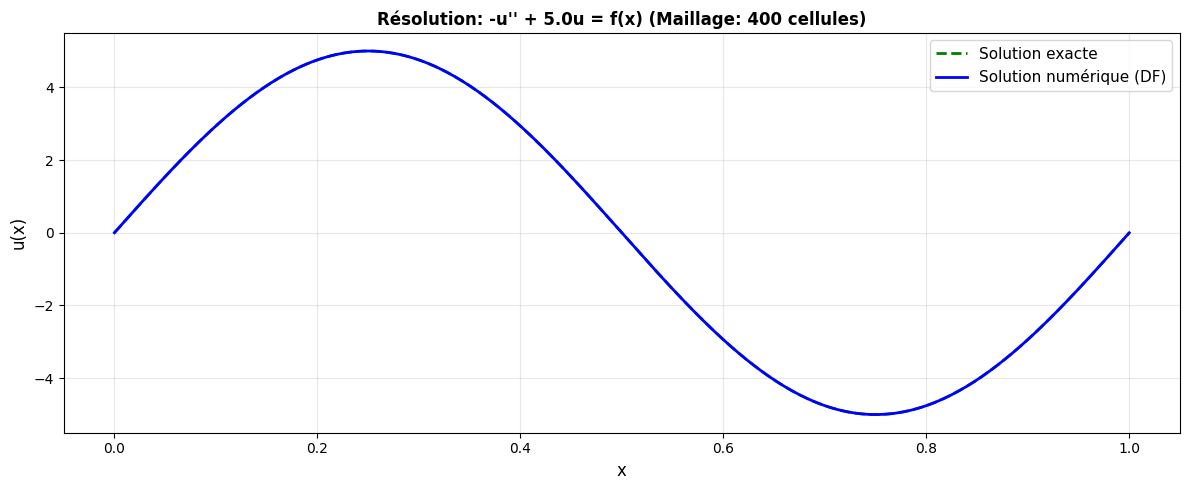

✓ Problème résolu avec Mesh1D:
  • Nœuds utilisés: 401 (dont 399 intérieurs)
  • Pas d'espace: 0.0025
  • Erreur L2: 6.452504e-05
  • Résidu (max): 2.475815e-10


In [8]:
# Solution analytique pour comparaison
u_ex = u_exact(x_complete, alpha)

# Plot
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(x_complete, u_ex, 'g--', linewidth=2, label='Solution exacte')
ax.plot(x_complete, u_sol_complete, 'b-', linewidth=2, label='Solution numérique (DF)')

# Marquer les nœuds du maillage
# ax.scatter(x_complete, u_sol_complete, c='red', s=50, zorder=5, label='Nœuds du maillage')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('u(x)', fontsize=12)
ax.set_title(f'Résolution: -u\'\' + {alpha}u = f(x) (Maillage: {mesh_1d.n_cells} cellules)', fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Erreur L2
error_l2 = np.sqrt(np.trapezoid((u_sol_complete - u_ex)**2, x_complete))
print(f"✓ Problème résolu avec Mesh1D:")
print(f"  • Nœuds utilisés: {N} (dont {N_int} intérieurs)")
print(f"  • Pas d'espace: {h:.4f}")
print(f"  • Erreur L2: {error_l2:.6e}")
print(f"  • Résidu (max): {np.max(np.abs(F(u_int_sol, h, alpha) - f_rhs)):.6e}")

### Dépendance à $\alpha$ : Calcul de la dérivée $\frac{\partial u}{\partial \alpha}$ avec `custom_vjp`

Pour un problème linéaire $A(\alpha)u(\alpha) = f(\alpha)$, on veut calculer comment la solution $u$ dépend du paramètre $\alpha$.

**Théorème de différentiation implicite :**

En dérivant l'équation par rapport à $\alpha$ :

$$\frac{\partial A}{\partial \alpha} \cdot u + A \cdot \frac{\partial u}{\partial \alpha} = \frac{\partial f}{\partial \alpha}$$

D'où :

$$\boxed{\frac{\partial u}{\partial \alpha} = A^{-1} \left(\frac{\partial f}{\partial \alpha} - \frac{\partial A}{\partial \alpha} \cdot u\right)}$$

**Implémentation avec `custom_vjp` :**

Le décorateur `@jax.custom_vjp` permet de définir manuellement le calcul du gradient (VJP = Vector-Jacobian Product) :

1. **`solve_fwd`** : Forward pass - calcule la solution $u(\alpha)$ et sauvegarde les données nécessaires
2. **`solve_bwd`** : Backward pass - calcule le VJP en utilisant le théorème implicite

**Fonction de coût :**

On s'intéresse à fonction de coût définie par la norme de la solution :

$$J(\alpha) = \|u(\cdot,\alpha)\|_{L^2(0,1)} = \sqrt{\int_0^1 u(x,\alpha)^2\,dx}.$$

Dans notre exemple analytique $u(x,\alpha)=\alpha\sin(2\pi x)$, on obtient :

$$J(\alpha)=\frac{\alpha}{\sqrt{2}}.$$

Pour la discrétisation, on utilise la version discrète :

$$J_h(\alpha)=\sqrt{\frac{1}{N+1}\sum_{i=0}^{N} u_i(\alpha)^2}.$$


In [9]:
def J(alpha):
    """Fonction de coût basée sur la norme L2 de u."""
    # Reconstruire u avec conditions de Dirichlet aux bords
    return alpha / jnp.sqrt(2)

def J_h(u):
    """Fonction de coût basée sur la norme L2 de u."""
    # Reconstruire u avec conditions de Dirichlet aux bords
    return jnp.sqrt(jnp.mean(u**2))

In [10]:
# Théorème de différentiation implicite
# Si A(α)u(α) = f(α), alors:
# ∂A/∂α · u + A · ∂u/∂α = ∂f/∂α
# Donc: ∂u/∂α = A^(-1) · (∂f/∂α - ∂A/∂α · u)

@jax.custom_vjp
def solve_linear_system(alpha, h, x_int):
    """Résout A(alpha) u = f(alpha) pour u."""
    # print("Primal computation")
    # Construire f(alpha)
    f_rhs = f_source(x_int, alpha)
    
    # Construire A(alpha) via la Jacobienne
    u_guess = jnp.zeros(len(x_int))
    A = jax.jacobian(F)(u_guess, h, alpha)
    
    # Résoudre
    u_int_sol = jnp.linalg.solve(A, f_rhs)
    return u_int_sol

def solve_fwd(alpha, h, x_int):
    """Forward pass: calcule u et sauvegarde les infos nécessaires pour le backward."""
    # print("Forward computation")
    u_int_sol = solve_linear_system(alpha, h, x_int)
    return u_int_sol, (alpha, h, x_int, u_int_sol)

def solve_bwd(res, g):
    """Backward pass: calcule le VJP."""
    # print("Backward computation")
    alpha, h, x_int, u_int_sol = res
    
    # g est le gradient venant d'en haut (∂L/∂u)
    # On veut calculer ∂L/∂α = (∂L/∂u) · (∂u/∂α)
    
    # Construire A(alpha) = ∂F/∂u
    u_guess = jnp.zeros(len(x_int))
    A = jax.jacobian(F, argnums=0)(u_guess, h, alpha)
    
    # ∂f/∂α : calcul automatique via vmap et grad
    # Pour chaque point x, calculer df/dα
    df_dalpha = jax.vmap(lambda x: jax.grad(lambda a: f_source(x, a))(alpha))(x_int)
    
    # ∂A/∂α · u : calcul général via JVP sur A(alpha)
    A_mat = lambda a: jax.jacobian(F, argnums=0)(u_guess, h, a)
    _, dA_dalpha = jax.jvp(A_mat, (alpha,), (1.0,))
    dA_dalpha_u = dA_dalpha @ u_int_sol
    # dA_dalpha_u = u_int_sol
    
    # ∂u/∂α = A^(-1) · (∂f/∂α - ∂A/∂α · u)
    du_dalpha = jnp.linalg.solve(A, df_dalpha - dA_dalpha_u)
    
    # VJP: ∂L/∂α = g^T · ∂u/∂α
    vjp_alpha = jnp.dot(g, du_dalpha)
    
    # Pas de gradient pour h et x_int (paramètres fixes)
    return (vjp_alpha, None, None)

solve_linear_system.defvjp(solve_fwd, solve_bwd)

# # Test: calculer ∂u/∂α
# alpha_test = 5.0

# print("@@ Compute u_int_sol_custom @@")
# u_int_sol_custom = solve_linear_system(alpha_test, h, x_int)

# # Gradient via custom_vjp
# print("@@ Compute gradient via custom_vjp @@")
# grad_fn = jax.grad(lambda a: jnp.sum(solve_linear_system(a, h, x_int)**2))
# du_dalpha_custom = grad_fn(alpha_test)

# print(f"✓ Gradient ∂(||u||²)/∂α calculé avec custom_vjp:")
# print(f"  • α = {alpha_test}")
# print(f"  • ∂(||u||²)/∂α = {du_dalpha_custom:.6f}")

# # Vérification par différences finies
# eps = 1e-5
# u_plus = solve_linear_system(alpha_test + eps, h, x_int)
# u_minus = solve_linear_system(alpha_test - eps, h, x_int)
# du_dalpha_fd = (jnp.sum(u_plus**2) - jnp.sum(u_minus**2)) / (2 * eps)

# print(f"\n✓ Vérification par différences finies:")
# print(f"  • ∂(||u||²)/∂α (DF) = {du_dalpha_fd:.6f}")
# print(f"  • Erreur relative: {abs(du_dalpha_custom - du_dalpha_fd) / abs(du_dalpha_fd):.6e}")

alpha_values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
@@ Compute solutions for varying alpha @@
Exact norms: [0.70710678 1.41421356 2.12132034 2.82842712 3.53553391 4.24264069
 4.94974747 5.65685425 6.36396103 7.07106781]
@@ Compute gradients for varying alpha @@


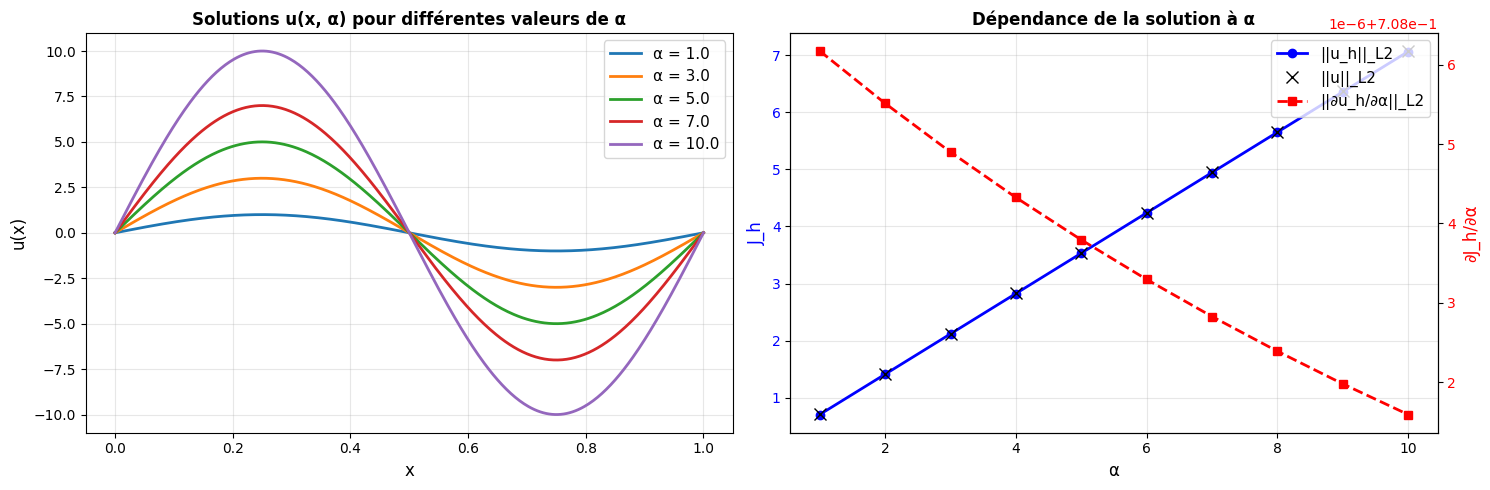

✓ Analyse de sensibilité:
  • Plage de α: [1.0, 10.0]
  • ||u(α=1.0)||₂ = 0.706239
  • ||u(α=10.0)||₂ = 7.062361


In [11]:
# Visualisation de la dépendance u(α)
alpha_values = jnp.linspace(1.0, 10.0, 10)
print("alpha_values:", alpha_values)
u_solutions = []
norms = []

print("@@ Compute solutions for varying alpha @@")
for a in alpha_values:
    u_int = solve_linear_system(a, h, x_int)
    u_sol = jnp.concatenate([jnp.array([0.0]), u_int, jnp.array([0.0])])
    u_solutions.append(u_sol)
    norms.append(J_h(u_sol))

u_solutions = jnp.array(u_solutions)
norms = jnp.array(norms)
exact_norms = jnp.array([J(a) for a in alpha_values])
print("Exact norms:", exact_norms)
# Calculer les gradients pour chaque α
print("@@ Compute gradients for varying alpha @@")
# grad_fn = jax.grad(lambda a: J_h(jnp.concatenate([jnp.array([0.0]), solve_linear_system(a, h, x_int), jnp.array([0.0])])))
grad_fn = jax.jacobian(lambda a: solve_linear_system(a, h, x_int))
gradients = jnp.array([J_h(grad_fn(a)) for a in alpha_values])

# Plot
plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1: Solutions u(x) pour différents α
for i, a in enumerate([1.0, 3.0, 5.0, 7.0, 10.0]):
    idx = jnp.argmin(jnp.abs(alpha_values - a))
    ax1.plot(x_complete, u_solutions[idx], label=f'α = {a:.1f}', linewidth=2)

ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('u(x)', fontsize=12)
ax1.set_title('Solutions u(x, α) pour différentes valeurs de α', fontsize=12, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Graphique 2: ||u|| en fonction de α et son gradient
ax2_twin = ax2.twinx()
ax2.plot(alpha_values, norms, 'b-', linewidth=2, marker='o', label='||u_h||_L2')
ax2.plot(alpha_values, exact_norms, linestyle='None', markersize=8, marker='x', color='black', label='||u||_L2')
ax2_twin.plot(alpha_values, gradients, 'r--', linewidth=2, marker='s', label="||∂u_h/∂α||_L2")


ax2.set_xlabel('α', fontsize=12)
ax2.set_ylabel('J_h', fontsize=12, color='b')
ax2_twin.set_ylabel("∂J_h/∂α", fontsize=12, color='r')
ax2.set_title('Dépendance de la solution à α', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='b')
ax2_twin.tick_params(axis='y', labelcolor='r')
ax2.grid(True, alpha=0.3)

# Légendes combinées
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print(f"✓ Analyse de sensibilité:")
print(f"  • Plage de α: [{alpha_values[0]:.1f}, {alpha_values[-1]:.1f}]")
print(f"  • ||u(α={alpha_values[0]:.1f})||₂ = {norms[0]:.6f}")
print(f"  • ||u(α={alpha_values[-1]:.1f})||₂ = {norms[-1]:.6f}")
# print(f"  • Décroissance: {(norms[0] - norms[-1]) / norms[0] * 100:.2f}%")

## Problème non-linéaire 1D

**Problème :** Considérons maintenant le problème de Poisson 1D avec un terme quadratique paramétré par $\alpha > 0$ :

$$\left\{\begin{align*}
-u''(x)+\alpha u^2(x) &= f(x),\quad x\in(0,1) \\
u(0) = u(1) &= 0\end{align*}\right.$$

Pour la résolution numérique, on fixe **$\alpha = 5$**, puis on étudiera la sensibilité de la solution à ce paramètre.

On considère la solution analytique $$u(x,\alpha) = \alpha\sin(2 \pi x).$$

**Schéma DF :** On considère un schéma différences finies (centré d'ordre 2) sur un maillage uniforme : 

$$\left\{\begin{align*}
-u_{i+1}+2u_i-u_{i-1} + \alpha h^2 u_i^2 &= h^2f_i,\quad i=1,\ldots,N-1 \\
u_0 = u_N &= 0\end{align*}\right.$$ 

Ce système est **non-linéaire**, on utilise donc la **méthode de Newton-Raphson** pour le résoudre :

$$\mathbf{u}^{(k+1)} = \mathbf{u}^{(k)} - J_F(\mathbf{u}^{(k)})^{-1} F(\mathbf{u}^{(k)})$$

où $F(\mathbf{u})$ est le résidu et $J_F$ sa Jacobienne.

In [12]:
def u_exact_nl(x, alpha):
    """Solution exacte du problème."""
    return alpha * jnp.sin(2 * jnp.pi * x)

def f_source_nl(x, alpha):
    """Fonction source f(x) correspondant à la solution exacte."""
    return (alpha**2 * jnp.sin(2 * jnp.pi * x) + (2 * jnp.pi)**2) * alpha * jnp.sin(2 * jnp.pi * x)

def F_nl(u_int, h, alpha, x_int):
    """Opérateur différentiel appliqué à u (intérieur uniquement)."""
    # Reconstruire u avec conditions de Dirichlet aux bords
    u = jnp.concatenate([jnp.array([0.0]), u_int, jnp.array([0.0])])
    # Laplacien par DF centré: -u''
    laplacian = -(u[2:] - 2*u[1:-1] + u[:-2]) / h**2
    # Terme non-linéaire: alpha*u^2
    nonlinear_term = alpha * u_int**2
    # Second membre f(x) - pour avoir une solution proche de sin(pi*x), on ajuste f
    f_rhs = f_source_nl(x_int, alpha)
    return laplacian + nonlinear_term - f_rhs

### Résolution numérique

On cherche à :
- résoudre le problème en construisant la matrice avec `jax`,
- vérifier que la matrice est constante par raport à u,
- comparer la solution numérique à la solution analytique.

In [13]:
# Paramètres du problème non-linéaire
alpha_nl = 4  # Coefficient du terme non-linéaire

# Méthode de Newton-Raphson (avec méthode de continuation)
alpha_start = 3.5
n_steps = 3
alpha_path = jnp.linspace(alpha_start, alpha_nl, n_steps)

u_nl_cont = jnp.zeros(N_int)
max_iter = 50
tol = 1e-8

jac_F = jax.jacobian(F_nl, argnums=0)
nb_iterations = []
for a in alpha_path:
    converge = False
    for k in range(max_iter):
        # Calculer le résidu
        F_k = F_nl(u_nl_cont, h, a, x_int)

        # Calculer la Jacobienne via JAX
        J_k = jac_F(u_nl_cont, h, a, x_int)
        
        # Résoudre le système linéaire: J * delta_u = -F
        delta_u = jnp.linalg.solve(J_k, -F_k)
        
        # Mise à jour
        u_nl_cont = u_nl_cont + delta_u
        
        # Critère de convergence
        residual_norm = jnp.linalg.norm(F_k)
        if residual_norm < tol:
            converge = True
            break
        # print("residual_norm =",residual_norm)
    nb_iterations.append(k)
    if not converge:
        print(f"⚠ Nombre maximum d'itérations atteint pour alpha = {a}")
        # print(f"  • Résidu final: {residual_norm:.6e}")

u_nl_cont_complete = jnp.concatenate([jnp.array([0.0]), u_nl_cont, jnp.array([0.0])])
print(f"✓ Problème non-linéaire résolu avec méthode de continuation:")
print("Nombre d'itérations par étape:", nb_iterations)

⚠ Nombre maximum d'itérations atteint pour alpha = 3.75
✓ Problème non-linéaire résolu avec méthode de continuation:
Nombre d'itérations par étape: [8, 49, 5]


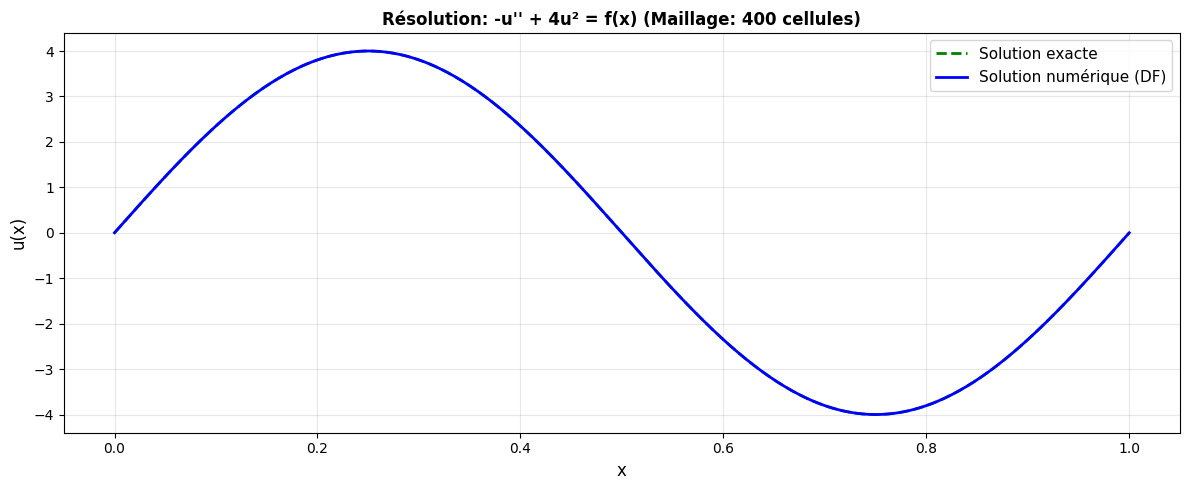

✓ Problème résolu avec Mesh1D:
  • Nœuds utilisés: 401 (dont 399 intérieurs)
  • Pas d'espace: 0.0025
  • Erreur L2: 4.643869e-04
  • Résidu (max): 1.545288e-10


In [14]:
# Solution analytique pour comparaison
u_ex_nl = u_exact_nl(x_complete, alpha_nl)

# Plot
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(x_complete, u_ex_nl, 'g--', linewidth=2, label='Solution exacte')
ax.plot(x_complete, u_nl_cont_complete, 'b-', linewidth=2, label='Solution numérique (DF)')

# Marquer les nœuds du maillage
# ax.scatter(x_complete, u_nl_cont_complete, c='red', s=50, zorder=5, label='Nœuds du maillage')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('u(x)', fontsize=12)
ax.set_title(f'Résolution: -u\'\' + {alpha_nl}u² = f(x) (Maillage: {mesh_1d.n_cells} cellules)', fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Erreur L2
error_l2 = np.sqrt(np.trapezoid((u_nl_cont_complete - u_ex_nl)**2, x_complete))
print(f"✓ Problème résolu avec Mesh1D:")
print(f"  • Nœuds utilisés: {N} (dont {N_int} intérieurs)")
print(f"  • Pas d'espace: {h:.4f}")
print(f"  • Erreur L2: {error_l2:.6e}")
print(f"  • Résidu (max): {np.max(np.abs(F_nl(u_nl_cont, h, alpha_nl, x_int))):.6e}")

### Dépendance à $\alpha$ : Calcul de la dérivée $\frac{\partial u}{\partial \alpha}$ avec `custom_vjp`

On cherche a mesurer la sensibilite de la solution au parametre $\alpha$ dans le cas non-lineaire. Le residu s'ecrit :

$$F(u,\alpha) = -u'' + \alpha u^2 - f(x,\alpha) = 0.$$

**Differentiation implicite :**

En derivant $F(u(\alpha),\alpha)=0$ par rapport a $\alpha$ :

$$\frac{\partial F}{\partial u}\,\frac{\partial u}{\partial \alpha} + \frac{\partial F}{\partial \alpha} = 0,$$

soit

$$\boxed{\frac{\partial u}{\partial \alpha} = -\left(\frac{\partial F}{\partial u}\right)^{-1}\frac{\partial F}{\partial \alpha}}.$$

Ici $\frac{\partial F}{\partial u}$ est la Jacobienne de Newton, et $\frac{\partial F}{\partial \alpha}$ se calcule automatiquement avec JAX.

**Implémentation avec `custom_vjp` :**

- **`solve_nl_fwd`** : resout le probleme non-lineaire (Newton) et sauvegarde $u$.
- **`solve_nl_bwd`** : resout un systeme lineaire avec la Jacobienne pour obtenir le VJP.

**Fonction de cout :**

$$J(\alpha)=\|u(\cdot,\alpha)\|_{L^2(0,1)}.$$

Pour la solution analytique $u(x,\alpha)=\alpha\sin(2\pi x)$, on a encore

$$J(\alpha)=\frac{\alpha}{\sqrt{2}},$$

et on utilisera en discret :

$$J_h(\alpha)=\sqrt{\frac{1}{N+1}\sum_{i=0}^{N} u_i(\alpha)^2}.$$

In [15]:
def J_nl(alpha):
    """Norme L2 analytique de u pour le cas non-lineaire."""
    return alpha / jnp.sqrt(2)


def J_h_nl(u):
    """Norme L2 discrete pour un vecteur u complet (bords inclus)."""
    return jnp.sqrt(jnp.mean(u**2))

In [16]:
def newton_solve_nl(alpha, h, x_int, max_iter=50, tol=1e-8):
    """Resolution non-lineaire par Newton pour un alpha donne."""
    u = jnp.zeros_like(x_int)
    jac_F = jax.jacobian(F_nl, argnums=0)

    for _ in range(max_iter):
        F_k = F_nl(u, h, alpha, x_int)
        J_k = jac_F(u, h, alpha, x_int)
        delta_u = jnp.linalg.solve(J_k, -F_k)
        u = u + delta_u
        if jnp.linalg.norm(F_k) < tol:
            break

    return u


@jax.custom_vjp
def solve_nonlinear_system(alpha, h, x_int):
    """Retourne u_int(alpha) en resolvant F(u, alpha) = 0."""
    return newton_solve_nl(alpha, h, x_int)


def solve_nl_fwd(alpha, h, x_int):
    """Forward pass: calcule u et sauvegarde les infos utiles."""
    u_int_sol = newton_solve_nl(alpha, h, x_int)
    return u_int_sol, (alpha, h, x_int, u_int_sol)


def solve_nl_bwd(res, g):
    """Backward pass: calcule le VJP via differentiation implicite."""
    alpha, h, x_int, u_int_sol = res

    # Jacobienne en u: dF/du
    J_u = jax.jacobian(F_nl, argnums=0)(u_int_sol, h, alpha, x_int)

    # Derivee par rapport a alpha: dF/dalpha (vecteur)
    dF_dalpha = jax.jacobian(F_nl, argnums=2)(u_int_sol, h, alpha, x_int)

    # du/dalpha = - J_u^{-1} * dF/dalpha
    du_dalpha = -jnp.linalg.solve(J_u, dF_dalpha)

    # VJP: dL/dalpha = g^T * du/dalpha
    vjp_alpha = jnp.dot(g, du_dalpha)

    return (vjp_alpha, None, None)


solve_nonlinear_system.defvjp(solve_nl_fwd, solve_nl_bwd)

alpha_values_nl: [0.5 1.  1.5 2.  2.5 3. ]
@@ Compute nonlinear solutions for varying alpha @@
Exact norms (nl): [0.35355339 0.70710678 1.06066017 1.41421356 1.76776695 2.12132034]
@@ Compute nonlinear gradients for varying alpha @@


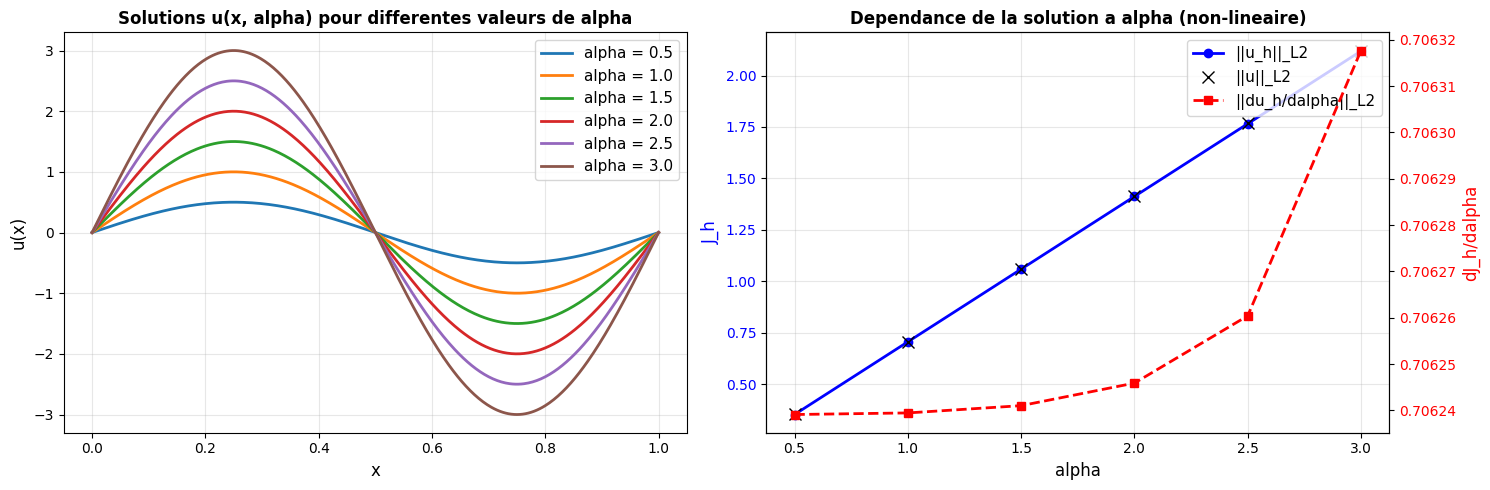

✓ Analyse de sensibilite (non-lineaire):
  • Plage de alpha: [0.5, 3.0]
  • ||u(alpha=0.5)||_2 = 0.353120
  • ||u(alpha=3.0)||_2 = 2.118747


In [17]:
# Visualisation de la dependance u(alpha) pour le cas non-lineaire
alpha_values_nl = jnp.linspace(0.5, 3.0, 6)
print("alpha_values_nl:", alpha_values_nl)

u_solutions_nl = []
norms_nl = []

print("@@ Compute nonlinear solutions for varying alpha @@")
for a in alpha_values_nl:
    u_int = solve_nonlinear_system(a, h, x_int)
    u_sol = jnp.concatenate([jnp.array([0.0]), u_int, jnp.array([0.0])])
    u_solutions_nl.append(u_sol)
    norms_nl.append(J_h_nl(u_sol))

u_solutions_nl = jnp.array(u_solutions_nl)
norms_nl = jnp.array(norms_nl)
exact_norms_nl = jnp.array([J_nl(a) for a in alpha_values_nl])
print("Exact norms (nl):", exact_norms_nl)

# Gradients d u par rapport a alpha
print("@@ Compute nonlinear gradients for varying alpha @@")
grad_fn_nl = jax.jacobian(lambda a: solve_nonlinear_system(a, h, x_int))

gradients_nl = []
for a in alpha_values_nl:
    du_int = grad_fn_nl(a)
    du_sol = jnp.concatenate([jnp.array([0.0]), du_int, jnp.array([0.0])])
    gradients_nl.append(J_h_nl(du_sol))

gradients_nl = jnp.array(gradients_nl)

# Plot
plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1: Solutions u(x) pour differents alpha
for a in alpha_values_nl:
    idx = jnp.argmin(jnp.abs(alpha_values_nl - a))
    ax1.plot(x_complete, u_solutions_nl[idx], label=f"alpha = {a:.1f}", linewidth=2)

ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('u(x)', fontsize=12)
ax1.set_title('Solutions u(x, alpha) pour differentes valeurs de alpha', fontsize=12, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Graphique 2: ||u|| en fonction de alpha et son gradient
ax2_twin = ax2.twinx()
ax2.plot(alpha_values_nl, norms_nl, 'b-', linewidth=2, marker='o', label='||u_h||_L2')
ax2.plot(alpha_values_nl, exact_norms_nl, linestyle='None', markersize=8, marker='x', color='black', label='||u||_L2')
ax2_twin.plot(alpha_values_nl, gradients_nl, 'r--', linewidth=2, marker='s', label='||du_h/dalpha||_L2')

ax2.set_xlabel('alpha', fontsize=12)
ax2.set_ylabel('J_h', fontsize=12, color='b')
ax2_twin.set_ylabel('dJ_h/dalpha', fontsize=12, color='r')
ax2.set_title('Dependance de la solution a alpha (non-lineaire)', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='b')
ax2_twin.tick_params(axis='y', labelcolor='r')
ax2.grid(True, alpha=0.3)

# Legendes combinees
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Analyse de sensibilite (non-lineaire):")
print(f"  • Plage de alpha: [{alpha_values_nl[0]:.1f}, {alpha_values_nl[-1]:.1f}]")
print(f"  • ||u(alpha={alpha_values_nl[0]:.1f})||_2 = {norms_nl[0]:.6f}")
print(f"  • ||u(alpha={alpha_values_nl[-1]:.1f})||_2 = {norms_nl[-1]:.6f}")